# Step 1: Import Libraries and Start MATLAB Engine

In [12]:
import seaborn as sns

In [1]:
import matplotlib.pyplot as plt
import statistics
import numpy as np
import random


import subprocess

import matlab.engine
# Start the MATLAB engine
eng = matlab.engine.start_matlab()

# Step 2: Run Initial Setup Scripts in MATLAB

In [2]:
# Run addWecSimSource.m to set up WEC-Sim
print("> Step 1: Running addWecSimSource.m...")
print("####################################################################################")
eng.run('/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/addWecSimSource.m', nargout=0)
print("> Step 1 executed successfully!")
print("     ")

# Run bemio.m to process hydrodynamic data
print("> Step 2: Running bemio.m...")
print("####################################################################################")
eng.run('/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/hydroData/bemio.m', nargout=0)
print("> Step 2 executed successfully!")
print("     ")

> Step 1: Running addWecSimSource.m...
####################################################################################
> Step 1 executed successfully!
     
> Step 2: Running bemio.m...
####################################################################################
> Step 2 executed successfully!
     


# Step 3: Define The Template And Output File Paths 

In [3]:
# Define the paths for the template and output MATLAB script files
template_path = '/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/wecSimInputFile.TEMPLATE.m'
output_path = '/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/wecSimInputFile.m'

# Step 4: Define Simulation Parameters

In [96]:
# Simulation parameters that stay constant
time_start = 0
time_end = 600
dt = 0.1

# # Define a range of PTO damping values to test
# pto_damping_values = np.linspace(1100000, 1300000, num=21)  # Define a range for exploration
# wave_heights_values = np.linspace(6, 10, num=11)
# wave_periods_values = np.linspace(1, 4, num=11)

pto_damping_values = np.linspace(1000000, 2000000, num=30)  # Define a range for exploration
wave_heights_values = np.linspace(20, 40, num=20)
wave_periods_values = np.linspace(10, 40, num=20)

pto_stiffness = 0

# Step 5: Run Simulations For Each PTO Damping Value

In [100]:
# Define the Epsilon-Greedy parameters
# Epsilon decay parameters
epsilon = 0.9 # Starting exploration rate 0.3
epsilon_min = 0.1  # Minimum exploration rate 0.01
num_episodes = 2000  # Total number of episodes to run
decay_interval = 200  # Apply decay every 'decay_interval' episodes
decay_factor = 0.75  # Decay factor to apply

epsilon_start=epsilon
epsilon_end=epsilon_min

In [101]:
episode_data = []
epsilon_values = []
all_rewards=[] # Keep all rewards for calculating running mean and std

# Function to calculate reward (placeholder, define your own)
def calculate_reward(float_velocity, spar_velocity, pto_damping, waves_height, waves_period, all_rewards):
    # Convert MATLAB data to Python lists
    float_velocity = [float(x[0]) for x in float_velocity]
    float_velocity = np.array(float_velocity)
    spar_velocity = [float(x[0]) for x in spar_velocity]
    spar_velocity = np.array(spar_velocity)
    
    # print("Shapes:", float_velocity.shape, spar_velocity.shape)
    
    relative_velocity=float_velocity-spar_velocity
    pto_power=pto_damping*np.square(relative_velocity)
    
    wave_power=((1000*pow(9.8068, 2))/(64*np.pi))*pow(waves_height, 2)*waves_period
    
    power=np.sum(np.abs(wave_power-pto_power))
    
    # Add raw power reward to list
    all_rewards.append(power)

    # Calculate running mean and standard deviation of rewards
    mean_reward = np.mean(all_rewards)
    std_reward = np.std(all_rewards) if np.std(all_rewards) > 0 else 1

    # Normalize the reward
    normalized_reward = (power - mean_reward) / std_reward

    return np.abs(normalized_reward)

# Initialize the estimated rewards and counts for each PTO damping value
estimated_rewards = {damping: 0 for damping in pto_damping_values}
counts = {damping: 0 for damping in pto_damping_values}

# Training loop
for episode in range(num_episodes):
    # Epsilon-Greedy action selection
    if random.random() < epsilon:
        # Exploration: choose a random PTO damping value
        chosen_pto_damping = random.choice(pto_damping_values)
        waves_height = np.random.choice(wave_heights_values)
        waves_period = np.random.choice(wave_periods_values)
    else:
        # Exploitation: choose the PTO damping value with the highest estimated reward
        chosen_pto_damping = max(estimated_rewards, key=estimated_rewards.get)
    
    # Use sed to update the wecSimInputFile with the current PTO damping value
    command = (
        f"sed 's/WAVES_HEIGHT/{waves_height}/g' '{template_path}' | "
        f"sed 's/WAVES_PERIOD/{waves_period}/g' | "
        f"sed 's/PTO_STIFFNESS/{pto_stiffness}/g' | "
        f"sed 's/TIME_START/{time_start}/g' | "
        f"sed 's/TIME_END/{time_end}/g' | "
        f"sed 's/DT/{dt}/g' | "
        f"sed 's/PTO_DAMPING/{chosen_pto_damping}/g' > '{output_path}'"
    )
    subprocess.run(command, shell=True, check=True)

    # Run the simulation in MATLAB
    eng.cd('/Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3/', nargout=0)
    eng.eval('wecSim', nargout=0)
    
    # Extract and calculate the reward based on simulation results
    reward = calculate_reward(
        eng.eval("output.bodies(1).velocity", nargout=1),
        eng.eval("output.bodies(2).velocity", nargout=1),
        chosen_pto_damping,
        waves_height,
        waves_period,
        all_rewards
    )

    # Update the estimated rewards and counts for the chosen PTO damping value
    counts[chosen_pto_damping] += 1
    old_reward = estimated_rewards[chosen_pto_damping]
    estimated_rewards[chosen_pto_damping] += (reward - old_reward) / counts[chosen_pto_damping]
    episode_data.append((episode + 1, chosen_pto_damping, reward))
    
    # Store the current value of epsilon
    epsilon_values.append(epsilon)
    
    # Apply scheduled decay
    if (episode + 1) % decay_interval == 0:
        epsilon = max(epsilon * decay_factor, epsilon_min)

    # # Print the result of the current episode
    # print(f"> Episode {episode + 1}: PTO Damping: {chosen_pto_damping} Newtons per meter/second , Reward: {reward} Watts")

# Determine the best PTO damping value after all episodes
best_pto_damping = max(estimated_rewards, key=estimated_rewards.get)
print(f"Best PTO damping value after {num_episodes} episodes is: {best_pto_damping}")

WEC-Sim: An open-source code for simulating wave energy converters
Version: 5.0.1

Initializing the Simulation Class...
	Case Dir: /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3 

WEC-Sim Input From Standard wecSimInputFile.m Of Case Directory... 
WEC-Sim: An open-source code for simulating wave energy converters
Version: 5.0.1

Initializing the Simulation Class...
	Case Dir: /Users/khalidalnahyan/Documents/GitHub/WEC-Sim-master/examples/RM3 
Elapsed time is 0.655880 seconds.

WEC-Sim Pre-processing ...   
	Infinite water depth specified in BEM and "waves.waterDepth" not specified in input file.
Set water depth to 200m for visualization.
Elapsed time is 0.126397 seconds.

WEC-Sim Simulation Settings:
	Start Time                     (sec) = 0
	End Time                       (sec) = 600
	Time Step Size                 (sec) = 0.1
	Ramp Function Time             (sec) = 100
	 Number of Time Steps     = 6000 

Wave Environment: 
	Wave Type                            = R

# Step 6: Analyze Results And Select Best Damping Value

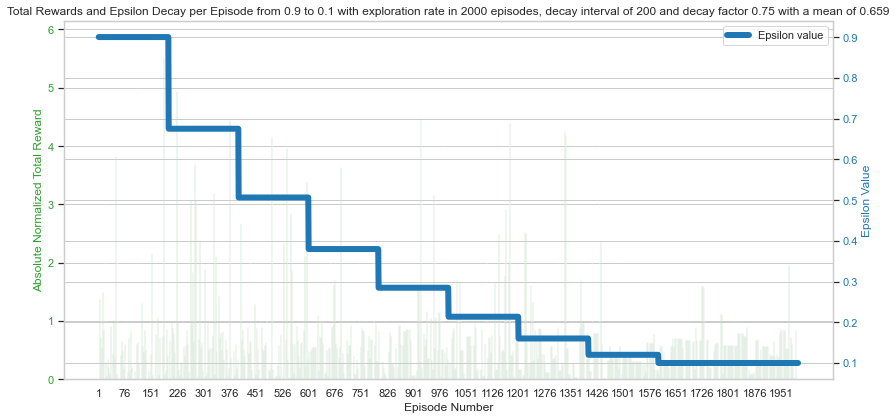

In [102]:
# # After the training loop
# for episode_number, damping_value, episode_reward in episode_data:
#     print(f"> Episode {episode_number}: PTO Damping: {damping_value} Newtons per meter/second, Reward: {episode_reward} Watts")
    
# # Determine the best PTO damping value after all episodes
# best_pto_damping = max(estimated_rewards, key=estimated_rewards.get)
# print(f"Best PTO damping value after {num_episodes} episodes is: {best_pto_damping}")

# Separate the episode numbers and rewards into two lists
episodes = [item[0] for item in episode_data]
rewards = [item[2] for item in episode_data]
average_reward = round(np.mean(rewards), 3)


# Set Seaborn style
sns.set(style="whitegrid", palette="pastel")



# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total rewards per episode with Seaborn barplot on the primary y-axis (left)
sns.barplot(x=episodes, y=rewards, ax=ax1, color='tab:green', alpha=0.2)
ax1.set_xlabel('Episode Number')
ax1.set_ylabel('Absolute Normalized Total Reward', color='tab:green')
ax1.tick_params(axis='y', labelcolor='tab:green')

# Set custom x-axis labels
ax1.set_xticks(np.arange(0, len(episodes), 75))  # Show every 25th label
ax1.set_xticklabels(episodes[::75])  # Assuming episodes list is in ascending order

# Create a secondary y-axis for the epsilon decay
ax2 = ax1.twinx()

# Plot epsilon decay on the secondary y-axis (right)
ax2.plot(epsilon_values, label='Epsilon value', color='tab:blue', linewidth=6)
ax2.set_ylabel('Epsilon Value', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')
ax2.legend(loc='upper right')

# Add title and show the plot
plt.title(f'Total Rewards and Epsilon Decay per Episode from {epsilon_start} to {epsilon_end} with exploration rate in {num_episodes} episodes, decay interval of {decay_interval} and decay factor {decay_factor} with a mean of {average_reward}')
fig.tight_layout()  # Adjust the layout to prevent clipping of ylabel

# Save the figure
fig.savefig("epsilon_decay_rewards_plot20.png", dpi=300)  # Adjust filename and DPI as needed

plt.show()

In [10]:
np.mean(rewards)

0.7466913061869358

# Step 7: Clean Up

In [107]:
# Close the MATLAB engine when done
eng.quit()